In [27]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Setting up Data
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()
import plotly.graph_objs as go
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout, BatchNormalization
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,mean_squared_error
from sklearn.model_selection import  train_test_split
from keras import backend as K
from keras import optimizers
import keras as k
import time
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [28]:
#中冷后进气压力/进气量/ 中冷后进气温度/冷却水温度/ EGR阀开度/实测氧浓度/实测碳烟排放
data = pd.read_csv("data.csv")
data.head()
print(data.shape)

(153164, 7)


In [29]:
data.describe()

,PIM,AIR_FLOW,THA,THW,LEGR,CEXREAL,soot
count,153164.000000,1.531640e+05,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000
mean,142.102809,3.220867e+02,47.722962,86.529002,26.890979,17.069849,1.354684
std,36.688846,1.540769e+02,2.698922,1.325697,13.582638,5.262626,1.254441
min,106.314072,1.400000e-08,31.174412,66.683716,0.000000,4.674084,-0.015000
25%,116.823456,2.233254e+02,46.525069,85.865845,19.905131,12.605148,0.629000
50%,126.253960,2.922540e+02,47.818195,86.558609,23.242093,18.143646,1.223000
75%,162.974701,4.117001e+02,49.151614,87.242167,31.760503,21.299297,1.802000
max,265.274353,9.227142e+02,57.733215,94.996307,91.331413,23.219999,50.917000


In [4]:
print('soot含量少于0g:',len(data[data['soot']<=0.0]))
print('soot含量大于20g:',len(data[data['soot']>=20.0]))      

soot含量少于0g: 5611
soot含量大于20g: 10


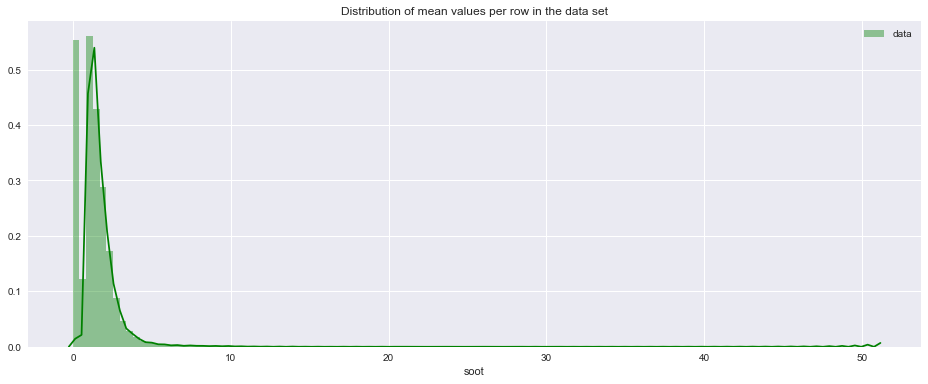

In [5]:
plt.figure(figsize=(16,6))
features = data['soot']
plt.title("Distribution of mean values per row in the data set")
sns.distplot(features,color="green", kde=True,bins=120, label='data')
#sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

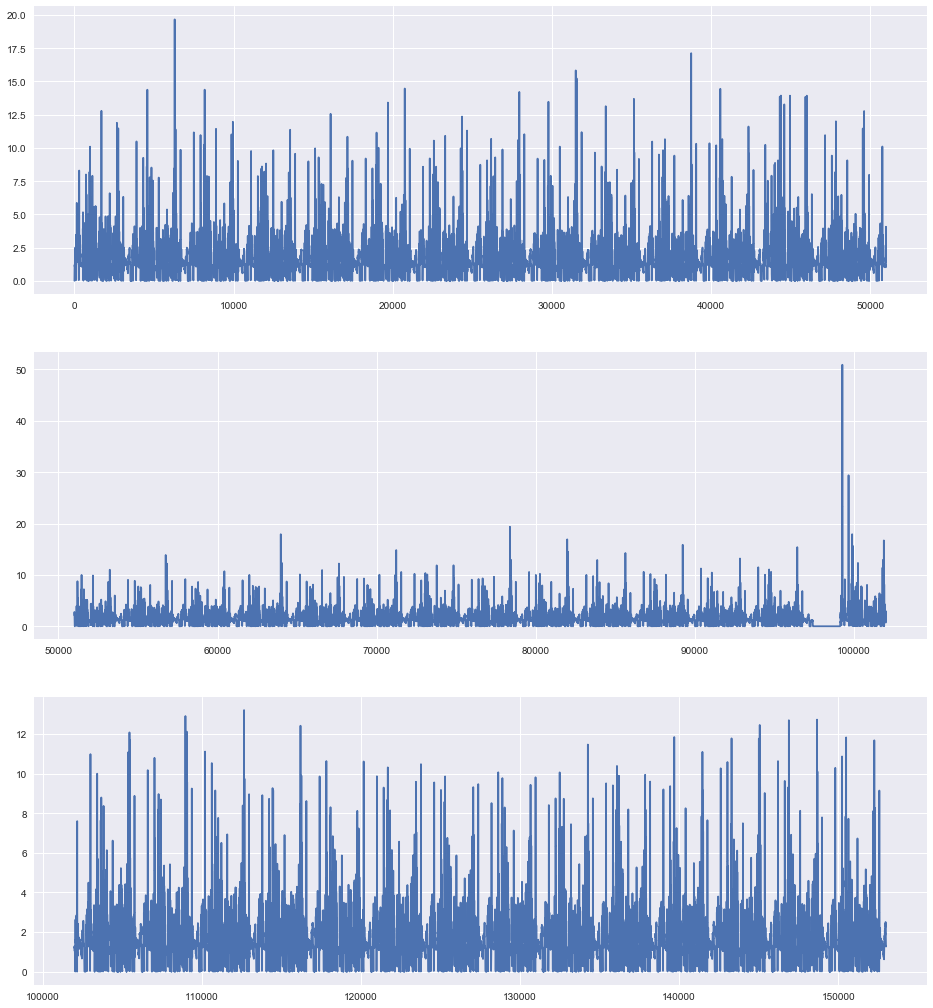

In [6]:
#90000个数据点到100000个数据点之间有数据异常，需要剔除
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(features[51000*i:51000*(i+1)])

              PIM    AIR_FLOW        THA        THW       LEGR    CEXREAL  \
99253  175.331390  449.794207  34.504471  82.575302  33.284348   9.702115   
99254  175.346909  476.138220  34.526733  82.657455  26.511086  10.317282   

         soot  
99253  50.917  
99254  50.917  


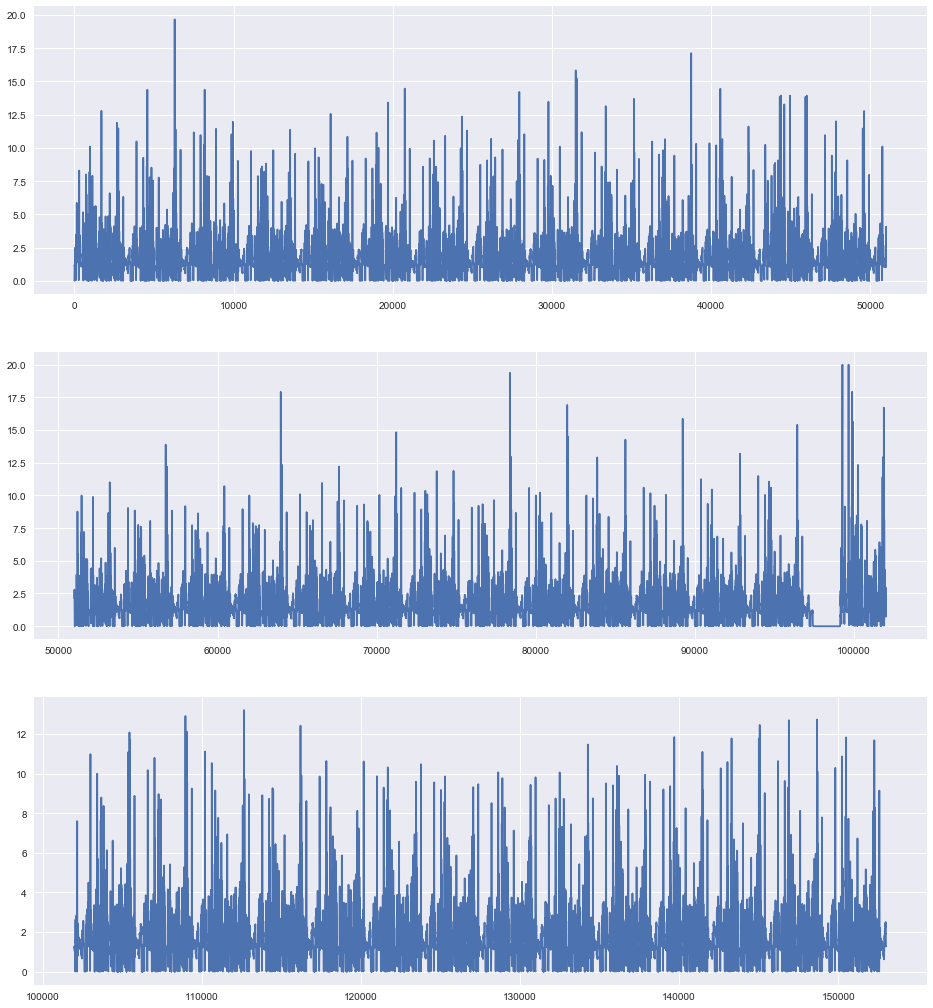

In [7]:
print(data[data['soot']>50])
f = lambda x : 20 if x>20 else x
data2 = data['soot'].map(f)
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(data2[51000*i:51000*(i+1)])

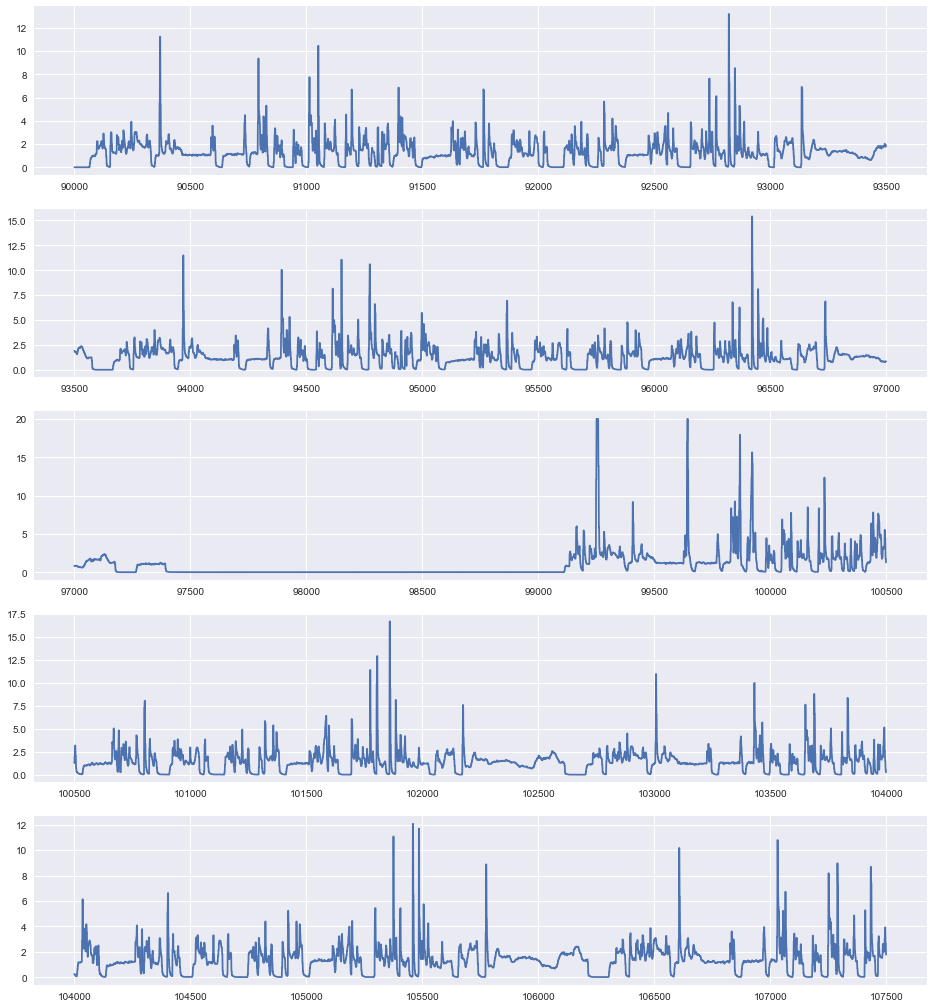

In [8]:
#
fig,ax=plt.subplots(5,1,figsize=(16,18))
for i in range(5):
    ax[i].plot(data2[90000+3500 * (i):(90000 + 3500 * (i+1))])

In [9]:
#将97000--100000范围的数据target修改
#print(len(data(data['soot'][97000:100000]) = 0))
data2[97000:100000] = -1

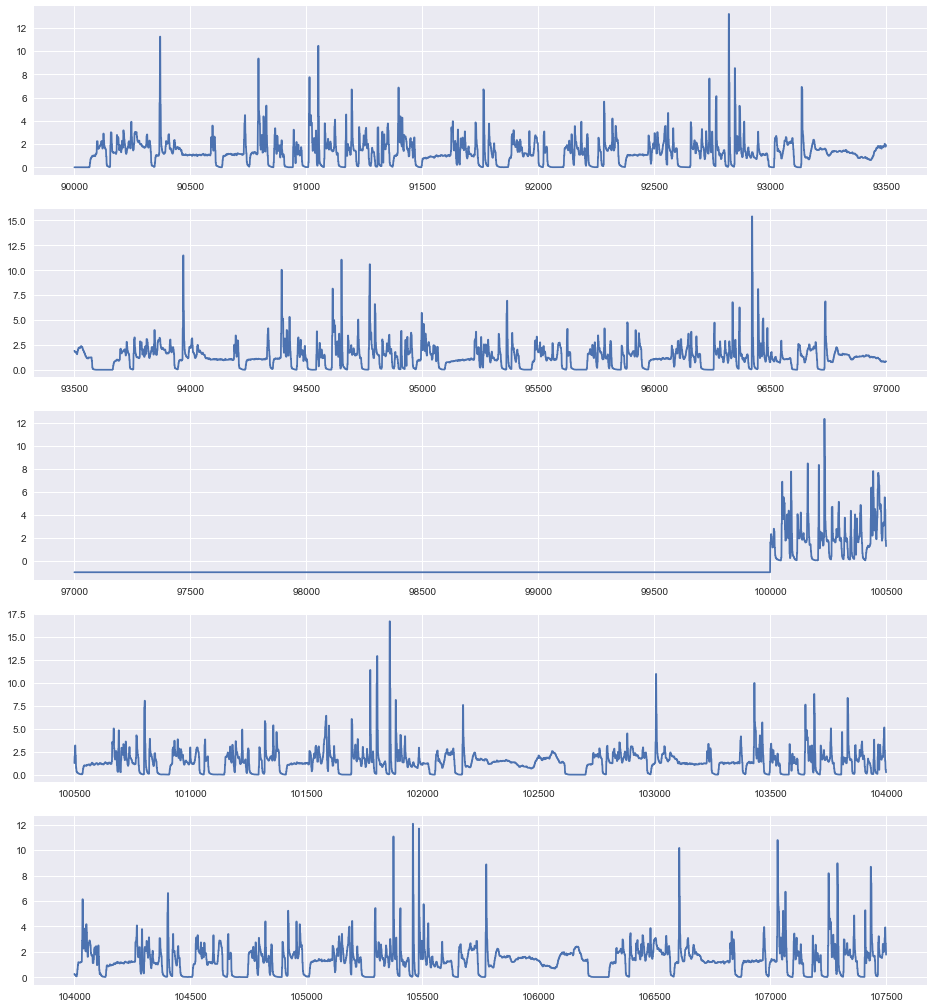

In [10]:
fig,ax=plt.subplots(5,1,figsize=(16,18))
for i in range(5):
    ax[i].plot(data2[90000+3500 * (i):(90000 + 3500 * (i+1))])

In [11]:
data['soot'][97000:100000] = -1
data.describe()

,PIM,AIR_FLOW,THA,THW,LEGR,CEXREAL,soot
count,153164.000000,1.531640e+05,153164.000000,153164.000000,153164.000000,153164.000000,153164.000000
mean,142.102809,3.220867e+02,47.722962,86.529002,26.890979,17.069849,1.318012
std,36.688846,1.540769e+02,2.698922,1.325697,13.582638,5.262626,1.239494
min,106.314072,1.400000e-08,31.174412,66.683716,0.000000,4.674084,-1.000000
25%,116.823456,2.233254e+02,46.525069,85.865845,19.905131,12.605148,0.524000
50%,126.253960,2.922540e+02,47.818195,86.558609,23.242093,18.143646,1.217000
75%,162.974701,4.117001e+02,49.151614,87.242167,31.760503,21.299297,1.795000
max,265.274353,9.227142e+02,57.733215,94.996307,91.331413,23.219999,19.672000


In [ ]:
g = sns.pairplot(data[[u'PIM', u'AIR_FLOW', u'THA', u'THW', u'LEGR', u'CEXREAL',
    u'soot']], hue='soot', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

KeyboardInterrupt: 

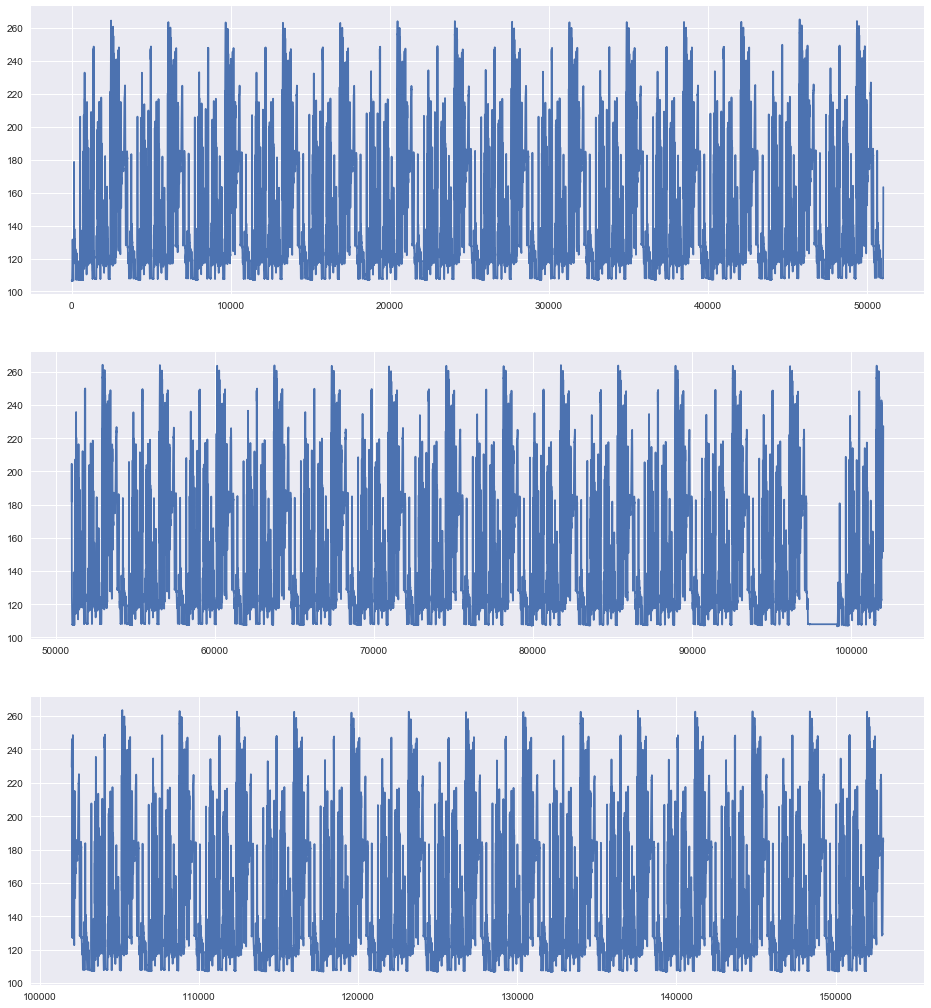

In [12]:
#观察其他标签的变化，是否保持一致??
#(1)PIM
data3 = data['PIM']
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(data3[51000*i:51000*(i+1)])

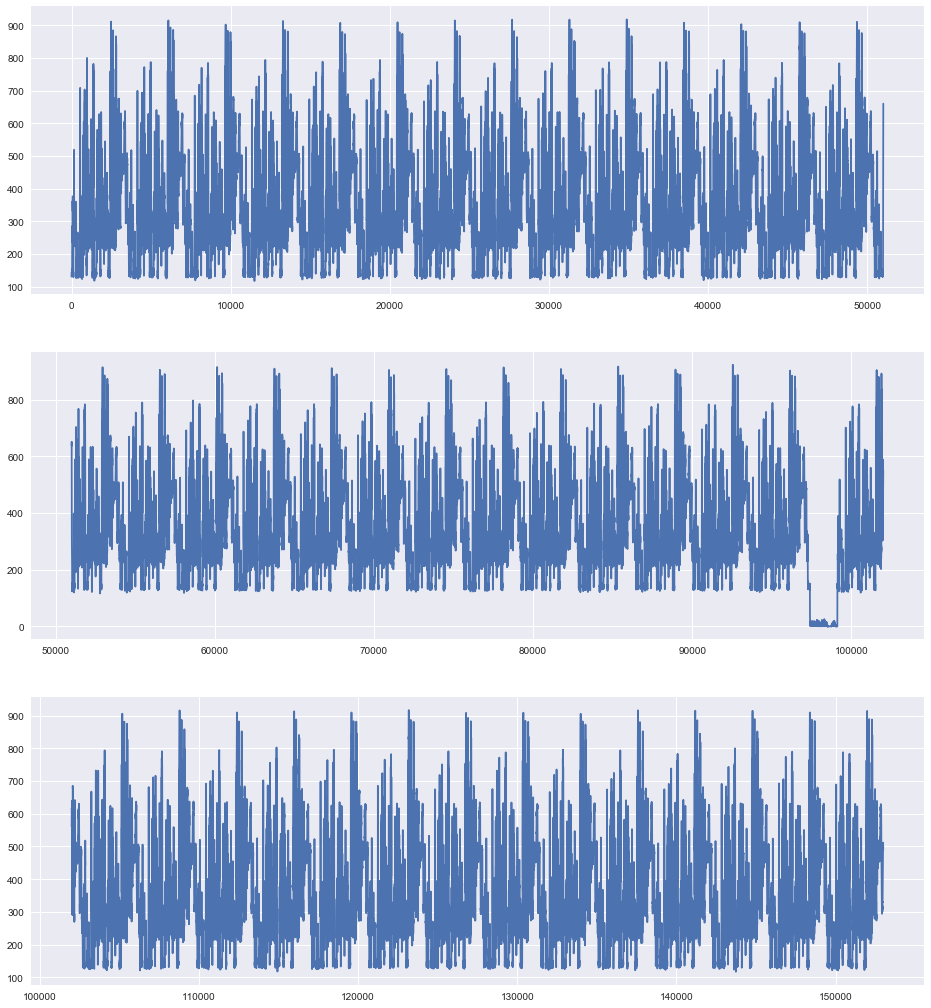

In [13]:
data4 = data['AIR_FLOW']
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(data4[51000*i:51000*(i+1)])

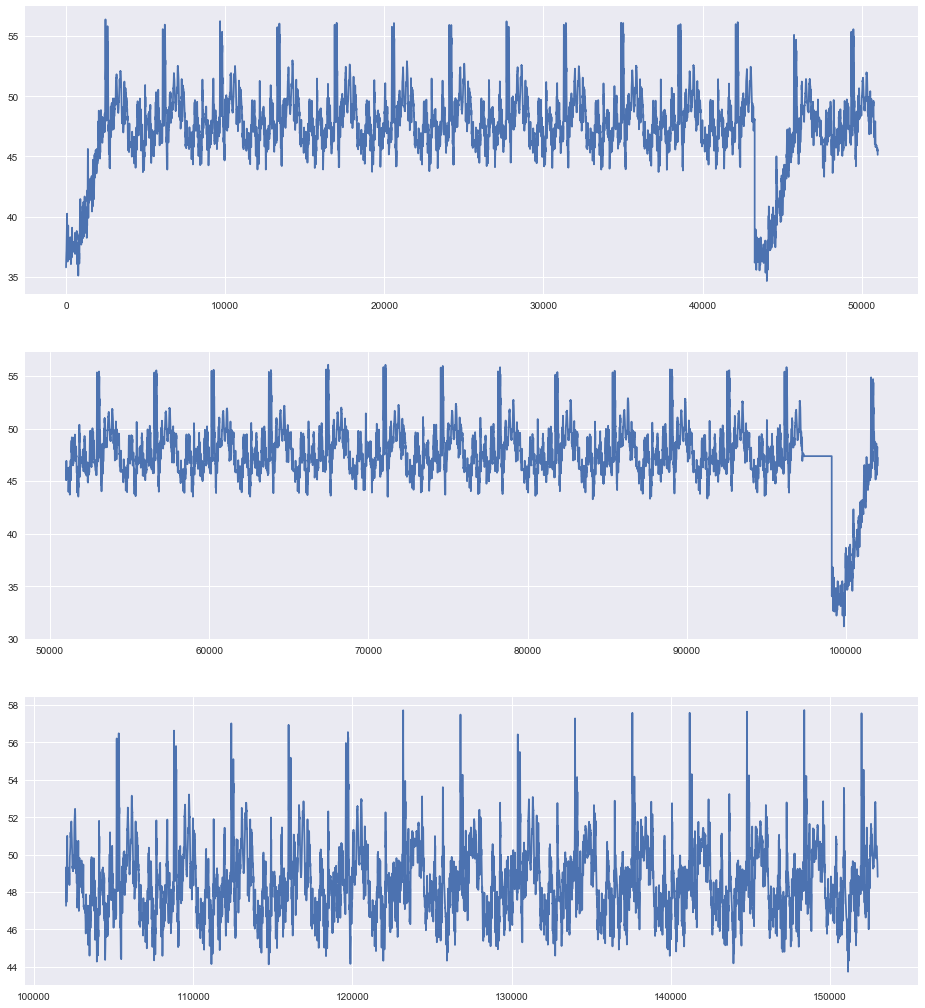

In [14]:
data5 = data['THA']
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(data5[51000*i:51000*(i+1)])

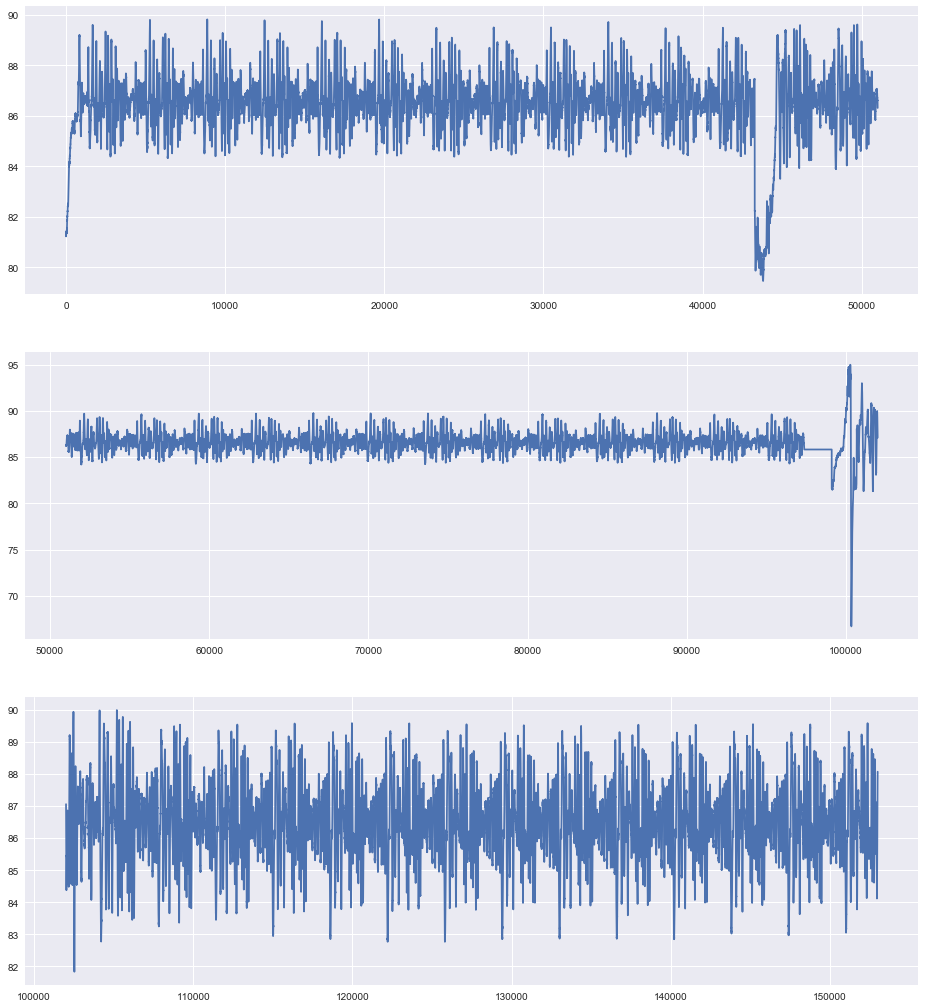

In [15]:
data6 = data['THW']
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(data6[51000*i:51000*(i+1)])

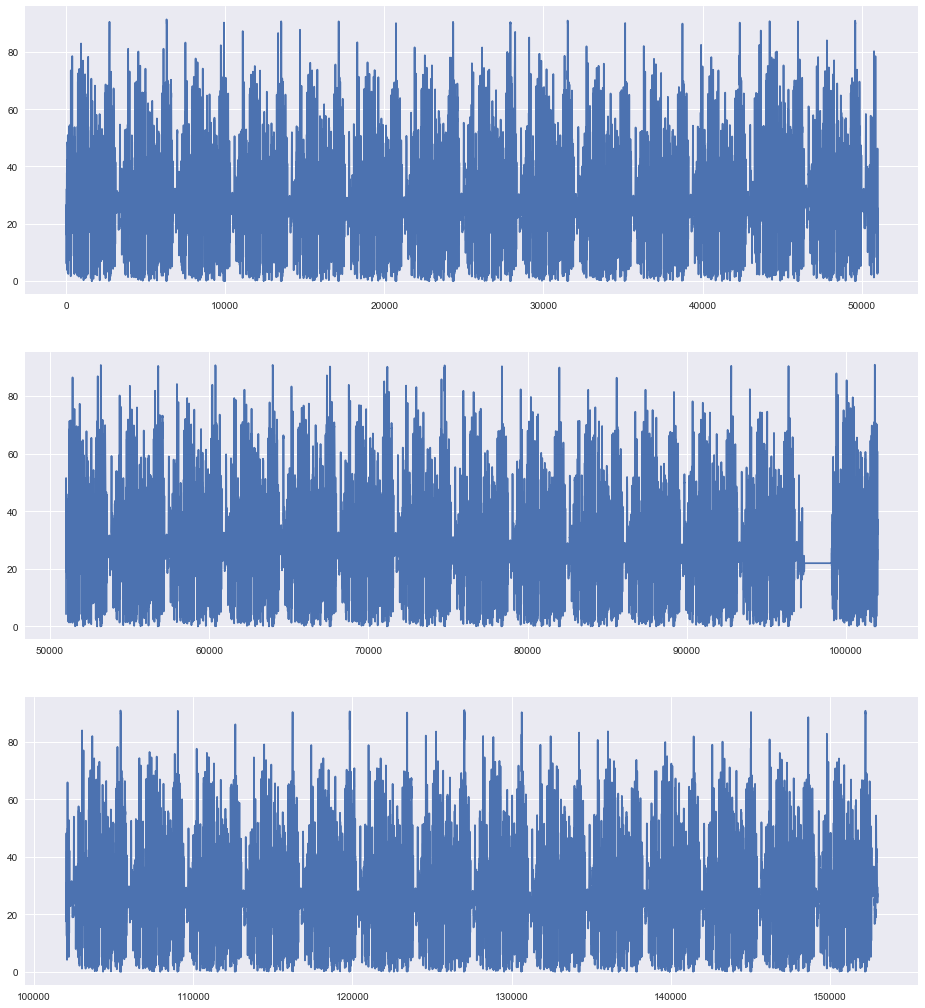

In [16]:
data7 = data['LEGR']
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(data7[51000*i:51000*(i+1)])

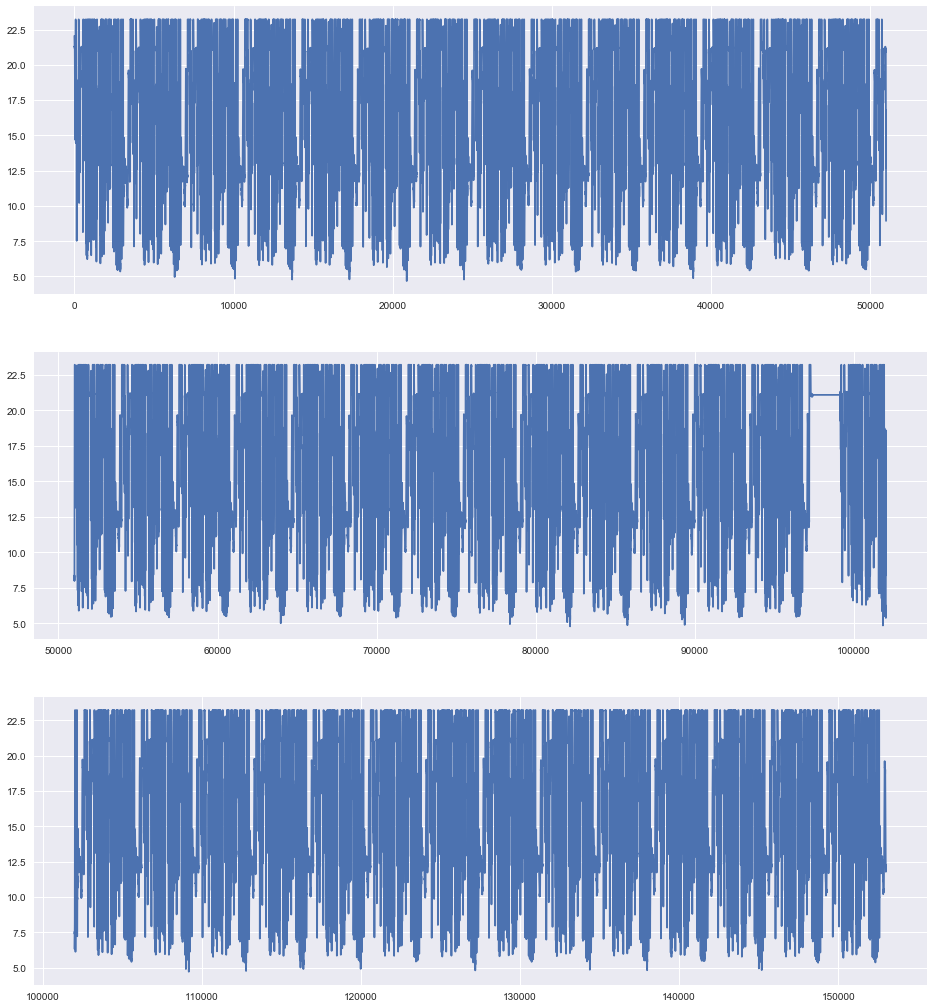

In [17]:
data8 = data['CEXREAL']
fig,ax=plt.subplots(3,1,figsize=(16,18))
for i in range(3):
    ax[i].plot(data8[51000*i:51000*(i+1)])

In [30]:
features = data.columns.values[0:5]
X = data[features]
y = data['soot']

#test train split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=2019)
print("X_train: ", X_train.shape)
print("X_test: " ,X_test.shape)


X_train:  (91898, 5)
X_test:  (61266, 5)


In [35]:
#Model LGBM 
def create_model_lgbm(X_train,y_train,X_val=None,y_val=None):
    dtrain = lgb.Dataset(X_train,label=y_train)
    dval = lgb.Dataset(X_val,label=y_val)
    param = {
    'bagging_freq': 8, #handling overfitting
    'bagging_fraction': 0.3,#handling overfitting - adding some noise
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.15, #handling overfitting
    'learning_rate': 0.01, #the changes between one auc and a better one gets really small thus a small learning rate performs better
    'max_depth': -1,  #smaller trees less overfitting
    'metric':'auc',
    'min_data_in_leaf': 80, #handling overfit
    'num_leaves': 35, #handling overfit
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'regression', 
    'verbosity': 0
    }
    if not X_val is None:
        valid_sets = (dtrain,dval)
        valid_names = ['train','valid']
    else:
        valid_sets = (dtrain)
        valid_names = ['train']
    model = lgb.train(param,dtrain,num_boost_round=300000,valid_sets=valid_sets,valid_names=['train','valid'],
                      verbose_eval=5000,
                     early_stopping_rounds=1000)
    return model

lgbm_X = X
lgbm_y = y
lgbm_test_x = X_test
lgbm_test_y = y_test
val_pred = np.zeros(len(lgbm_X))
full_pred = np.zeros(len(X))
importand_folds = np.zeros(lgbm_X.shape[1])
test_pred_lgbm = np.zeros(len(lgbm_test_y))
#target_pred = np.zeros(len(df_test))
kf = KFold(n_splits=4,random_state=20)
for _fold, (trn_idx, val_idx) in enumerate(kf.split(lgbm_X.values, lgbm_y.values)):
        Xtrn, ytrn = lgbm_X.iloc[trn_idx], lgbm_y.iloc[trn_idx]
        Xval, y_val = lgbm_X.iloc[val_idx], lgbm_y.iloc[val_idx]
        ones_train = (sum(ytrn>0) / len(ytrn))*100
        ones_val = (sum(y_val>0) / len(y_val))*100
        print('-'*50)
        print("Fold num:{}".format(_fold + 1))
        print('Trn Perc: 1: {:.2f}%, 0: {:.2f}%'.format(ones_train,100-ones_train))
        print('Validation Perc: 1 : {:.2f}%, 0:{:.2f}%'.format(ones_val,100-ones_val))
        print('-'*50)
        clf = create_model_lgbm(Xtrn,ytrn,Xval,y_val)
        val_pred[val_idx] = clf.predict(lgbm_X.iloc[val_idx])
        importand_folds += clf.feature_importance()
        test_pred_lgbm  += clf.predict(lgbm_test_x) / kf.n_splits
        full_pred += clf.predict(X) / kf.n_splits
        #target_pred += clf.predict(df_test.iloc[:,1:]) / kf.n_splits

val_cv_score = mean_squared_error(lgbm_y, val_pred)   
print('Val CV score : {}'.format(val_cv_score))   

--------------------------------------------------
Fold num:1
Trn Perc: 1: 96.08%, 0: 3.92%
Validation Perc: 1 : 97.11%, 0:2.89%
--------------------------------------------------
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[4]	train's auc: 0.886334	valid's auc: 0.801478
--------------------------------------------------
Fold num:2
Trn Perc: 1: 96.58%, 0: 3.42%
Validation Perc: 1 : 95.62%, 0:4.38%
--------------------------------------------------
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[4]	train's auc: 0.887765	valid's auc: 0.809325
--------------------------------------------------
Fold num:3
Trn Perc: 1: 97.58%, 0: 2.42%
Validation Perc: 1 : 92.62%, 0:7.38%
--------------------------------------------------
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[2]	train's auc: 0.819052	valid's auc: 0.731879
-------------------

In [38]:
X_train = data[features].values
y_train = data['soot'].values
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(data))
#predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    #predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))

fold n°1
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.72904	valid_1's l2: 0.774836
[400]	training's l2: 0.58343	valid_1's l2: 0.647111
[600]	training's l2: 0.516534	valid_1's l2: 0.594899
[800]	training's l2: 0.474289	valid_1's l2: 0.56668
[1000]	training's l2: 0.443199	valid_1's l2: 0.546807
[1200]	training's l2: 0.417467	valid_1's l2: 0.531613
[1400]	training's l2: 0.395971	valid_1's l2: 0.520154
[1600]	training's l2: 0.377386	valid_1's l2: 0.510108
[1800]	training's l2: 0.361145	valid_1's l2: 0.502146
[2000]	training's l2: 0.346651	valid_1's l2: 0.4959
[2200]	training's l2: 0.333733	valid_1's l2: 0.490101
[2400]	training's l2: 0.321954	valid_1's l2: 0.484876
[2600]	training's l2: 0.311184	valid_1's l2: 0.480309
[2800]	training's l2: 0.300742	valid_1's l2: 0.476031
[3000]	training's l2: 0.291227	valid_1's l2: 0.472475
[3200]	training's l2: 0.282478	valid_1's l2: 0.469314
[3400]	training's l2: 0.274367	valid_1's l2: 0.466404
[3600]	training's l

[9200]	training's l2: 0.145194	valid_1's l2: 0.471906
[9400]	training's l2: 0.142719	valid_1's l2: 0.4715
[9600]	training's l2: 0.140349	valid_1's l2: 0.471111
[9800]	training's l2: 0.138133	valid_1's l2: 0.470633
[10000]	training's l2: 0.135819	valid_1's l2: 0.47028
Did not meet early stopping. Best iteration is:
[10000]	training's l2: 0.135819	valid_1's l2: 0.47028
fold n°4
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.723832	valid_1's l2: 0.82756
[400]	training's l2: 0.579337	valid_1's l2: 0.696186
[600]	training's l2: 0.51385	valid_1's l2: 0.643506
[800]	training's l2: 0.472158	valid_1's l2: 0.613351
[1000]	training's l2: 0.440769	valid_1's l2: 0.591405
[1200]	training's l2: 0.415823	valid_1's l2: 0.574703
[1400]	training's l2: 0.395223	valid_1's l2: 0.562519
[1600]	training's l2: 0.376648	valid_1's l2: 0.55113
[1800]	training's l2: 0.360515	valid_1's l2: 0.542374
[2000]	training's l2: 0.346143	valid_1's l2: 0.535755
[2200]	training's l2: 0.3

KeyboardInterrupt: 

In [ ]:
num_features = 5
indxs = np.argsort(importand_folds/ kf.n_splits)[:num_features]
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance()[indxs],X.columns[indxs])), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Top {} LightGBM Features accorss folds'.format(num_features))
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances.png')